In [239]:
import pandas as pd
import numpy as np
import psycopg2
import math
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as scs
sns.set(font_scale=1.5)

In [240]:
#Create connection and cursor
conn = psycopg2.connect("dbname=pfxbaseballdata")
cur = conn.cursor()

In [241]:
# Define query
query = """
SELECT DISTINCT fgd.play_guid, bst.games, bst.pa, bst.hr, bst.r, bst.rbi 
    , bst.sb, bst.bb_percent, bst.k_percent, bst.iso, bst.babip, bst.ba_avg
    , bst.obp, bst.slg, bst.woba, bst.wrc_plus, bst.bsr, bst.off, bst.def
    , bst.war, bst.playerid, fgd.batter_id, fgd.ab_id, fgd.des, fgd.stand, fgd.strikes
    , fgd.balls, fgd.p_throws, fgd.pdes, fgd.inning, pst.wins, pst.losses, pst.saves, pst.games
    , pst.games_started, pst.innings_pitched, pst.k_per_9, pst.bb_per_9 
    , pst.hr_per_9, pst.babip, pst.lob_percent, pst.gb_percent, pst.hr_fb_percent
    , pst.era, pst.fip, pst.xfip, pst.war, pst.playerid  
FROM fg_game_data AS fgd
INNER JOIN pitcher_stats_table AS pst ON fgd.pitcher_fg_id = pst.playerid
INNER JOIN batter_stats_table AS bst ON fgd.batter_fg_id = bst.playerid
;
"""
#Execute the query
cur.execute(query)
# Return the next row
GameData = cur.fetchall()

In [242]:
GameData_df = pd.DataFrame(GameData, columns=['play_guid','b_games', 'b_pa', 'b_hr', 'b_r', 'b_rbi', 'b_sb',
                                    'b_bb_percent', 'b_k_percent','b_iso', 'b_babip', 'b_ba_avg', 'b_obp', 'b_slg', 'b_wOBA',
                                    'b_wrc_plus', 'b_bsr', 'b_off', 'b_def', 'b_war', 'b_playerid','b_mlb_id','ab_id', 'outcome',
                                    'stand', 'strikes', 'balls','p_throws','pitch_outcome', 'inning','p_wins', 'p_losses','p_saves','p_games', 
                                    'p_games_started', 'p_innings_pitched','p_k_per_9','p_bb_per_9','p_hr_per_9', 'p_babip', 
                                    'p_lob_percent','p_gb_percent','p_hr_fb_percent','p_era', 'p_fip', 'p_xfip', 'p_war','p_playerid'])

cleanGameData_df = GameData_df

In [243]:
#convert right vs left hander batter to binary
batter_stance = []
for batter in GameData_df.loc[:,]['stand']:
    if batter == 'R':
        batter_stance.append(1)
    else:
        batter_stance.append(0)
cleanGameData_df['batter_stance'] = batter_stance

In [244]:
#convert right vs left hander pitcher to binary
right_left_handness = []
for pitcher in GameData_df.loc[:,]['p_throws']:
    if pitcher == 'R':
        right_left_handness.append(1)
    else:
        right_left_handness.append(0)
cleanGameData_df['pitcher_handedness'] = right_left_handness

In [227]:
cleanGameData_df

,play_guid,b_games,b_pa,b_hr,b_r,b_rbi,b_sb,b_bb_percent,b_k_percent,b_iso,...,p_lob_percent,p_gb_percent,p_hr_fb_percent,p_era,p_fip,p_xfip,p_war,p_playerid,batter_stance,pitcher_handedness
0,00196e90-9dcc-4190-93bd-61dae9783fc7,688,2720,81,267,294,11,0.066,0.155,0.157,...,0.696,0.522,0.114,4.59,4.21,4.18,5.9,10123,0,1
1,0035bdb9-e6f2-4d14-a2e1-9dd795710304,365,1313,32,152,112,44,0.066,0.183,0.167,...,0.699,0.582,0.120,3.91,3.38,3.32,7.1,13431,0,1
2,00360ef6-9fdc-4fad-b858-463e8b961456,1398,6280,133,874,662,134,0.091,0.096,0.144,...,0.807,0.435,0.103,2.73,3.20,3.23,17.2,1642,1,1
3,004d8f6e-aa10-4781-82d7-4e793bd93aac,829,3649,60,449,322,199,0.056,0.104,0.126,...,0.750,0.542,0.109,3.16,3.29,3.24,51.1,4772,1,1
4,004db648-ea63-46b1-b5e4-d6d6d7b197c5,1173,5069,146,676,566,118,0.120,0.215,0.172,...,0.717,0.506,0.128,3.92,3.50,3.28,11.8,6632,0,1
5,00506f15-9eee-41f4-91be-ac545e411181,295,1117,39,134,136,10,0.095,0.258,0.197,...,0.684,0.390,0.135,4.58,4.55,4.09,4.8,9388,0,1
6,00524629-1d4e-4b0c-970a-2571c8dece70,1268,4845,238,637,678,38,0.124,0.269,0.228,...,0.752,0.417,0.120,3.72,3.58,3.47,8.7,5867,1,1
7,005bc624-47ab-46fe-9afa-b27319264cb8,779,3353,140,497,507,99,0.140,0.220,0.227,...,0.684,0.390,0.135,4.58,4.55,4.09,4.8,9388,1,1
8,006efb4b-d3c7-4c27-86a0-9b05b5f5b92b,1268,4845,238,637,678,38,0.124,0.269,0.228,...,0.698,0.476,0.114,4.22,3.64,3.53,10.0,6785,1,0
9,00764c0a-552a-4412-8bf5-d04e1460ddaa,962,4115,151,483,508,35,0.155,0.174,0.196,...,0.747,0.423,0.091,3.66,3.98,4.23,7.5,10197,0,1


In [245]:
#Convert probabilities within data set to log odds for logistic regression analysis
#Log Odds: LO = LOGe[Odds]= LOGe[p/(1-p)] 
def proba_to_logodds(probability):
    odds = (probability / (1 - probability))
    logodds = math.log(odds)
    return logodds
#test    
proba_to_logodds(.2)

-1.3862943611198906

In [246]:
#Columns to convert to logodds
columns_to_convert = ["b_bb_percent", "b_k_percent", "b_ba_avg", "b_obp", "b_slg", "p_lob_percent",
                      "p_gb_percent", "p_hr_fb_percent"]
labels = ["BB_logodds", "K_logodds", "BA_AVG_logodds", "b_OBP_logodds", "b_SLG_logodds", 
          "p_lob_logodds","p_gb_logodds", "p_hr_fb_logodds"]

In [247]:
def convert_to_logodds(list_DFs, labels):
    for idx, DF in enumerate(list_DFs):
        temp_lst = []
        for i in GameData_df.iloc[:,][DF]:
            temp_lst.append(proba_to_logodds(i))
        cleanGameData_df[labels[idx]] = temp_lst
        
convert_to_logodds(columns_to_convert, labels)

In [187]:
#AB_outcome predictions
cleanGameData_df = cleanGameData_df.drop(columns=["b_bb_percent", "b_k_percent", "b_ba_avg", "b_obp", "b_slg", "p_lob_percent",
                      "p_gb_percent", "p_hr_fb_percent", "play_guid", "outcome", "p_throws", "stand","b_playerid","b_mlb_id",'p_playerid', 'strikes', 'balls'])


In [248]:
#Single Pitch Outcome
cleanGameData_df = cleanGameData_df.drop(columns=["play_guid","b_bb_percent", "b_k_percent", 
                                                  "b_ba_avg","b_obp", "b_slg", "p_lob_percent",
                                                  "p_gb_percent", "p_hr_fb_percent","outcome",
                                                  "p_throws","stand", "pitch_outcome"])

In [232]:
cleanGameData_df

,b_games,b_pa,b_hr,b_r,b_rbi,b_sb,b_iso,b_babip,b_wOBA,b_wrc_plus,...,batter_stance,pitcher_handedness,BB_logodds,K_logodds,BA_AVG_logodds,b_OBP_logodds,b_SLG_logodds,p_lob_logodds,p_gb_logodds,p_hr_fb_logodds
0,688,2720,81,267,294,11,0.157,0.266,0.309,92,...,0,1,-2.649822,-1.695912,-1.114677,-0.833053,-0.388826,0.828322,0.088057,-2.050519
1,365,1313,32,152,112,44,0.167,0.297,0.320,105,...,0,1,-2.649822,-1.496153,-1.056390,-0.786131,-0.302281,0.842540,0.330989,-1.992430
2,1398,6280,133,874,662,134,0.144,0.315,0.355,117,...,1,1,-2.301486,-2.242481,-0.842540,-0.549416,-0.220894,1.430633,-0.261480,-2.164327
3,829,3649,60,449,322,199,0.126,0.334,0.342,118,...,1,1,-2.824774,-2.153550,-0.795448,-0.601503,-0.253346,1.098612,0.168397,-2.100997
4,1173,5069,146,676,566,118,0.172,0.342,0.366,129,...,0,1,-1.992430,-1.295046,-0.944462,-0.485306,-0.192593,0.929629,0.024001,-1.918759
5,295,1117,39,134,136,10,0.197,0.312,0.330,101,...,0,1,-2.254058,-1.056390,-1.093286,-0.740019,-0.208755,0.772216,-0.447312,-1.857455
6,1268,4845,238,637,678,38,0.228,0.305,0.360,123,...,1,1,-1.955085,-0.999702,-1.087974,-0.610260,-0.080043,1.109308,-0.335101,-1.992430
7,779,3353,140,497,507,99,0.227,0.356,0.392,145,...,1,1,-1.815290,-1.265666,-0.852064,-0.413805,0.100083,0.772216,-0.447312,-1.857455
8,1268,4845,238,637,678,38,0.228,0.305,0.360,123,...,1,0,-1.955085,-0.999702,-1.087974,-0.610260,-0.080043,0.837792,-0.096074,-2.050519
9,962,4115,151,483,508,35,0.196,0.269,0.354,124,...,0,1,-1.695912,-1.557539,-1.114677,-0.553728,-0.224944,1.082676,-0.310470,-2.301486


In [189]:
#Binary Outcome for logistic regression
ab_outcome = [] 
ball_in_play = ['Single', 'Double', 'Triple', 'Home Run']
for pitch in GameData_df.loc[:,]['outcome']:
    if pitch in ball_in_play and 'Play' not in pitch:
        ab_outcome.append(1)
    else:
        ab_outcome.append(0)
cleanGameData_df['ab_outcome'] = ab_outcome

In [249]:
#Onyl run for pitch outcome!!!

#Binary Outcome for logistic regression
outcome = [] 
for pitch in GameData_df.loc[:,]['pitch_outcome']:
    if 'play' in pitch:
        if 'no' in pitch or 'run' in pitch:
            outcome.append(1) #1 indicates hit
        else:
            outcome.append(0)
    else:
        outcome.append(0) #0 indicates a non-hit outcome
cleanGameData_df['pitch_outcome'] = outcome

In [261]:
cleanGameData_df

,b_games,b_pa,b_hr,b_r,b_rbi,b_sb,b_iso,b_babip,b_wOBA,b_wrc_plus,...,pitcher_handedness,BB_logodds,K_logodds,BA_AVG_logodds,b_OBP_logodds,b_SLG_logodds,p_lob_logodds,p_gb_logodds,p_hr_fb_logodds,pitch_outcome
0,688,2720,81,267,294,11,0.157,0.266,0.309,92,...,1,-2.649822,-1.695912,-1.114677,-0.833053,-0.388826,0.828322,0.088057,-2.050519,0
1,365,1313,32,152,112,44,0.167,0.297,0.320,105,...,1,-2.649822,-1.496153,-1.056390,-0.786131,-0.302281,0.842540,0.330989,-1.992430,0
2,1398,6280,133,874,662,134,0.144,0.315,0.355,117,...,1,-2.301486,-2.242481,-0.842540,-0.549416,-0.220894,1.430633,-0.261480,-2.164327,0
3,829,3649,60,449,322,199,0.126,0.334,0.342,118,...,1,-2.824774,-2.153550,-0.795448,-0.601503,-0.253346,1.098612,0.168397,-2.100997,0
4,1173,5069,146,676,566,118,0.172,0.342,0.366,129,...,1,-1.992430,-1.295046,-0.944462,-0.485306,-0.192593,0.929629,0.024001,-1.918759,0
5,295,1117,39,134,136,10,0.197,0.312,0.330,101,...,1,-2.254058,-1.056390,-1.093286,-0.740019,-0.208755,0.772216,-0.447312,-1.857455,0
6,1268,4845,238,637,678,38,0.228,0.305,0.360,123,...,1,-1.955085,-0.999702,-1.087974,-0.610260,-0.080043,1.109308,-0.335101,-1.992430,0
7,779,3353,140,497,507,99,0.227,0.356,0.392,145,...,1,-1.815290,-1.265666,-0.852064,-0.413805,0.100083,0.772216,-0.447312,-1.857455,0
8,1268,4845,238,637,678,38,0.228,0.305,0.360,123,...,0,-1.955085,-0.999702,-1.087974,-0.610260,-0.080043,0.837792,-0.096074,-2.050519,0
9,962,4115,151,483,508,35,0.196,0.269,0.354,124,...,1,-1.695912,-1.557539,-1.114677,-0.553728,-0.224944,1.082676,-0.310470,-2.301486,0


In [262]:
# fit a logistic regression model and store the class predictions
logreg = LogisticRegression(C=1e9)
X = np.array(cleanGameData_df.iloc[:,0:45])
y = np.array(cleanGameData_df['pitch_outcome'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)
logreg.fit(X_train, y_train)
#hit_proba = logreg.predict_proba(X)
logodds_pred = logreg.predict_log_proba(X_test)
proba_pred = logreg.predict_proba(X_test)
basic_log_score = logreg.score(X_test, y_test)

In [27]:
pd.crosstab(cleanGameData_df.strikes, cleanGameData_df.ab_outcome)

ab_outcome,0,1
strikes,,
0,903,260
1,678,189
2,667,133


In [28]:
pd.crosstab(cleanGameData_df.balls, cleanGameData_df.ab_outcome)

ab_outcome,0,1
balls,,
0,934,281
1,687,163
2,394,107
3,233,31


In [263]:
probabilities = []
for i in proba_pred:
    probabilities.append(i[1])

In [264]:
probabilities

[0.049030347596228076,
 0.07671133876082117,
 0.0612210509841127,
 0.07712414798867095,
 0.05621229892275377,
 0.052077030958802784,
 0.02929566004851832,
 0.07564419002541943,
 0.07293642327805734,
 0.07211975685126468,
 0.042184040119191295,
 0.06721326776296789,
 0.07601079349321074,
 0.05915498973120633,
 0.05591473580047395,
 0.04639070769803546,
 0.044451302968234706,
 0.06438102425517356,
 0.048439618060103135,
 0.06141978438717833,
 0.05149589963410181,
 0.0541215182953449,
 0.047755413169156734,
 0.06206285099282326,
 0.07598505594789919,
 0.09040750896430873,
 0.06581577512017299,
 0.03164156169337523,
 0.07874750591814172,
 0.06951563608983335,
 0.0874616333332012,
 0.029346388251797834,
 0.05825924402217429,
 0.10046453206625582,
 0.0730491810450923,
 0.06768574743447267,
 0.04513437806364631,
 0.044731141680934575,
 0.04840518190821497,
 0.07491547398780253,
 0.03763637239585493,
 0.05194039857713638,
 0.06498638315891954,
 0.03890932531513318,
 0.05410377656565326,
 0.088

In [265]:
roc_curve = metrics.roc_curve(y_true=y_test, y_score=proba_pred[:,1])

roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=proba_pred[:,1])
print(roc_auc)

0.4681078691423519


In [266]:
cleanGameData_df['pitch_outcome'].mean()

0.06287530907806428

In [267]:
logreg.coef_

array([[-2.54704523e-04, -1.38654049e-04,  2.22804892e-05,
        -3.02439643e-04,  2.34835078e-04, -3.52887011e-04,
        -6.38069469e-08, -1.86034773e-07, -1.77326284e-07,
        -3.85227118e-05, -1.23887012e-04, -1.40541211e-04,
        -2.18352320e-04, -3.98241712e-05,  2.54803162e-06,
        -3.18109011e-06,  3.08622891e-05,  9.08391088e-06,
         8.85812457e-06,  5.25202790e-06,  1.53659014e-05,
        -2.20242652e-05,  4.98683630e-05, -6.63377344e-04,
         4.88104236e-05, -2.36229519e-04, -1.11794100e-05,
        -4.13338118e-06, -6.87699126e-07, -1.35421853e-07,
        -1.55195082e-06, -1.13986273e-06, -8.90594759e-07,
        -1.07960341e-05, -2.30418056e-05,  2.54621280e-06,
         1.33396466e-06, -1.78727814e-07, -9.19089181e-08,
         4.48673133e-07, -1.52274868e-08,  1.73843988e-07,
        -9.71982250e-07,  9.89915509e-07,  7.94129644e-07]])

In [268]:
#Random Forest Model
'''sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                              max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, 
                                              random_state=None, verbose=0, warm_start=False, class_weight=None)
'''
RFC = RandomForestClassifier(random_state=16, n_estimators=100)
RFC.fit(X_train, y_train)
rf_predict_proba = RFC.predict_proba(X_test)
tree_split = RFC.decision_path(X_test)
feature_importance = RFC.feature_importances_
feature_importance

array([0.01266419, 0.01350795, 0.01095462, 0.01228596, 0.00970295,
       0.0147001 , 0.00913014, 0.01130634, 0.01024328, 0.00992699,
       0.01475702, 0.0105502 , 0.01506552, 0.01160671, 0.01446296,
       0.01348927, 0.13029676, 0.15195663, 0.16660007, 0.10398875,
       0.00961342, 0.01014963, 0.00523423, 0.01182583, 0.01024963,
       0.01184384, 0.01093655, 0.01077976, 0.01054458, 0.00964206,
       0.00978441, 0.01228827, 0.01108957, 0.00873033, 0.01303572,
       0.00242441, 0.00213292, 0.01423766, 0.01392391, 0.01336535,
       0.01076877, 0.00906721, 0.01007232, 0.0093192 , 0.01174401])

In [269]:
(y_test == (rf_predict_proba[:, 1]> 0.7)).mean()

0.9294117647058824

In [270]:
y_test.mean()

0.06951871657754011

In [271]:
roc_curve = metrics.roc_curve(y_true=y_test, y_score=rf_predict_proba[:,1])

roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=rf_predict_proba[:,1])
print(roc_auc)

0.6677718832891246


ValueError: x and y must be the same size

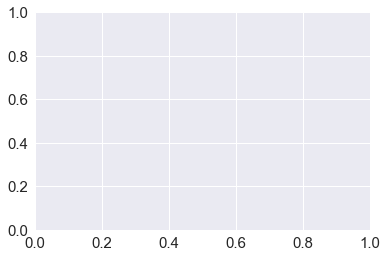

In [272]:
plt.scatter(x=rf_predict_proba[:,1], y=(np.zeros(934)), s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, 
                          vmax=None, alpha=0.5, linewidths=None, verts=None, edgecolors=None, hold=None, data=None)



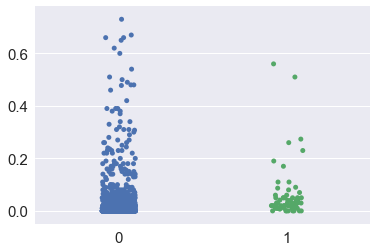

In [273]:
ax = sns.stripplot(x=y_test, y=rf_predict_proba[:,1], jitter=True)

KeyboardInterrupt: 

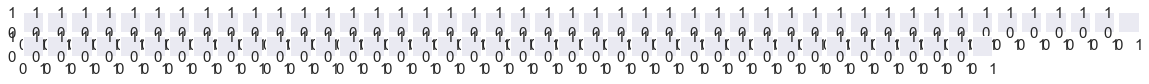

In [274]:
pd.plotting.scatter_matrix(cleanGameData_df, figsize=(20,20))

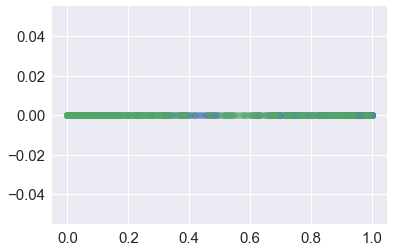

In [241]:
X = rf_predict_proba
y = np.zeros(934)

fig, ax = plt.subplots()
ax.plot(X, y, 'o', alpha=0.3)

In [206]:
fpr, tpr, _ = metrics.roc_curve(y_test, rf_predict_proba[:,1])

In [54]:
logreg = LogisticRegression()
X = np.array(cleanGameData_df['WAR'])
X = X.reshape(-1,1)
y = np.array(cleanGameData_df['ab_outcome'])
logreg.fit(X, y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
# fit a logistic regression model and store the class predictions
logreg = LogisticRegression(C=1e9)
X = np.array(cleanGameData_df['WAR'])
y = np.array(cleanGameData_df['ab_outcome'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)
logreg.fit(X_train, y_train)
#hit_proba = logreg.predict_proba(X)
logodds_pred = logreg.predict_log_proba(X_test)
proba_pred = logreg.predict_proba(X_test)
basic_log_score = logreg.score(X_test, y_test)

ValueError: Expected 2D array, got 1D array instead:
array=[ 4.2 17.5 15.9 ... 17.4 10.7  8.9].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.